# Выполнил Кирилл Сетдеков

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chisquare
import scipy
from scipy import stats
from statsmodels.stats.weightstats import *
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.stats.descriptivestats import sign_test

from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

#  Задание 1

1. Что можно сказать про случайные величины $X$ и $Y$, если $Corr(X, Y) = 1$?

    * Между этими величинами можно построить линейную зависимость вида $X = a + b Y$

2. Чем отличаются коэффициенты корреляции Пирсона и Спирмена? В каких случаях лучшепользоваться коэффициентом корреляции Спирмена?

    * Корреляцию Пирсона мы считаем между значениями величин, которые мы сравниваем, а для корреляции Спирмена используем позиции значений в вариационном ряду, составленном для каждой величины.

    * В ситуации, когда у нас есть упорядоченные категориальные значения, для которых мы можем делать папарные сравнения и есть транзитивность, то мы сможем между двумя величинами такого типа посчитать корреляцию Спирмена. Тажке, если мы ожидаем сразу не линейную зависимость, а некую зависимость вида $X = f(Y)$, где $f()$ - монотонная функция, то корреляция Спирмена будет лучше отражать картину корреляции между переменными.
    

3. Что такое коэффициент детерминации? Что происходит с коэффициентом детерминации, придобавлении признаков в регрессионную модель? А при удалении?

    * Коэффициент детерминации - отношение объясненной регрессией дисперсии к общей дисперсии $y$. Или в терминах ошибки: $$R^2 = 1 - \frac{RSS}{TSS}$$, где TSS - дисперсия y, а RSS - дисперсия остатков модели.* $R^2$ монотонно неубывает при добавлении новых переменных. При добавлении нового признака он может или остаться тем же или вырасти. Аналогично при удалении - может упасть, может не измениться. Отсюда следует одна из проблем - эта метрика не штрафует добавление малозначимых или совсем ненужных признаков.

4. В каких предположениях работают критерии Стьюдента и Фишера о значимости коэффициентов регрессии?

    * При выполнении предпосылок Теоремы Гаусса-Маркова:
    
        1. Модель линейна, совпадает с подлежащим процессом и включены все верные переменные
        2. Наблюдения случайны и независимы между собой 
        3. Ранг матрицы признаков равен числу столбцов - нет линейно зависимых переменных
        4. Ошибки имеют одинаковую дисперсию и нет гетероскедастичности
        5. Ошибки нормально распределены со средним 0.

5. Какую гипотезу проверяет критерий Фишера (F-тест), когда мы вызываем summary при по-строении линейной регрессии в Python или R?

    * В этом случае проверяется нулевая гипотеза, что все коэффициенты равны 0: $H_0: \beta_1 = \beta_2 = ... = \beta_n = 0 $



# Задание 2
В файле lifeline.xls содержатся 50 пар наблюдений из исследованиядокторов Л. Матера и М. Уилсона. В нем рассматривались следующие переменные:X длина линии жизни на левой руке в сантиметрах (с точностью до 0.15см) и Y  продолжительностьжизни человека (округленная до ближайшего целого года). Изучите корреляцию X и Y. Верно ли,что X и Y связаны линейной регрессионной зависимостью?

<AxesSubplot:xlabel='X', ylabel='Y'>

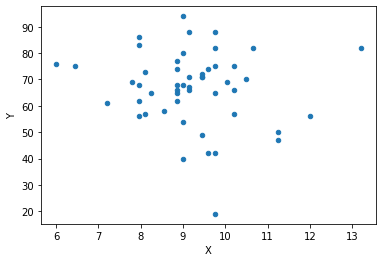

In [2]:
lines = pd.read_excel('data/lifeline.xls')
lines.plot.scatter(x = 'X', y = 'Y')

не очень похоже на связь

In [3]:
stats.pearsonr(lines.X, lines.Y)

(-0.12255365085952201, 0.3965106928959566)

Отвергнуть предположение о том, что линейной связи между этими факторами нет мы не можем. На этих данных не верно предположение, что X и Y связаны.

посчитать коэффициент корреляции до удаления выбросов и затем после, но это не очень критично, помимо этого можно дополнительно считать коэффициент корреляции Кенделла

In [4]:
stats.spearmanr(lines.X, lines.Y)

SpearmanrResult(correlation=-0.08601349137019551, pvalue=0.5525613938198386)

In [8]:
stats.kendalltau(stats.rankdata(lines.X), stats.rankdata(lines.Y))

KendalltauResult(correlation=-0.044979908444122044, pvalue=0.6559222232961208)

In [9]:
from sklearn.svm import OneClassSVM


In [18]:
ad = OneClassSVM(nu=0.05, kernel='rbf')
    
y_pred = ad.fit_predict(lines)

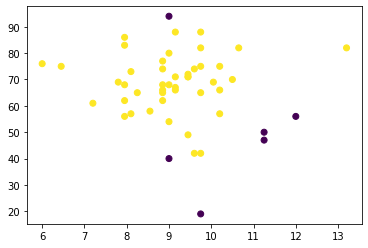

In [19]:
plt.scatter(lines.X, lines.Y,  c=y_pred)

Отфильтруем данные, которые будут выбросами

In [26]:
lines_short = lines[y_pred == 1]
stats.pearsonr(lines_short.X, lines_short.Y)

(0.0700322189858582, 0.6514684342539931)

In [27]:
stats.spearmanr(lines_short.X, lines_short.Y)

SpearmanrResult(correlation=0.09920374856594669, pvalue=0.5217288883538689)

In [28]:
stats.kendalltau(stats.rankdata(lines_short.X), stats.rankdata(lines_short.Y))

KendalltauResult(correlation=0.08385119952354311, pvalue=0.4393787870954323)

Удаление выбросов повысило PV, еще тяжелее отвергнуть гипотезу об отсутствии связи

# Задание 3
В файле auto.csv находятся данные, которые описывают характеристики 392 автомобилей. 

Какие признаки влияют на расход топлива? Постройте (хорошую) линейную регрессионную модельдля предсказания расхода топлива по этим признакам. Интерпретируйте значения коэффициентоврегрессии (влияние каждого признака на отклик). Не забудьте о преобразовании признаков, еслиони будут нужны.


In [4]:
mtcars = pd.read_csv('data/auto.csv')

Моя первая идея - даже до того, как смотреть данные - обогадить информацию для моделей машин информацией о их коэффициенте лобового сопротивления, что должно влиять на их суммарное лобовое сопротивление и на экономичность, связанную с этим (отдельно от двигателя). Оказалось, что найходить такие данные долго и медленно, поэтому я заполнил только часть машин. Даже в таком виде, это оказалось не самый плохой фактор.

In [5]:
# mtcars_names = mtcars.groupby('name').aggregate('mean')[['cylinders', 'year']]
# mtcars_names.to_csv('carnames.csv')

In [6]:
mtcars_names = pd.read_csv('carnames.csv')
mtcars_names

,name,cylinders,year,cda
0,amc ambassador brougham,8.0,73.0,0.47
1,amc ambassador dpl,8.0,70.0,0.47
2,amc ambassador sst,8.0,72.0,0.47
3,amc concord,5.0,79.0,0.45
4,amc concord d/l,6.0,78.0,0.48
...,...,...,...,...
296,vw dasher (diesel),4.0,80.0,0.42
297,vw pickup,4.0,82.0,0.43
298,vw rabbit,4.0,78.0,0.42
299,vw rabbit c (diesel),4.0,80.0,0.42


In [7]:
mtcars_names = pd.read_csv('carnames.csv')
mtcars = pd.merge(mtcars, mtcars_names[['name', 'cda']], how='left', on='name')
mtcars

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,cda
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0.55
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0.48
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,NaN
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0.50
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,NaN
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl,0.46
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup,0.43
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage,NaN
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger,NaN


In [8]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
mtcars['cda'] = imp_mean.fit_transform(np.array(mtcars.cda).reshape(-1, 1)) # заменим данные лобового сопротивления, которые я не успел достать на средние

Регрессия в лоб, как базовый уровень - целимся R-квадрат adjusted иметь на таком уровне, R-squared поднять выше 0,822

In [9]:
m1 = smf.ols('mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + origin + cda', data=mtcars)
m1fitted = m1.fit()

print(m1fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     221.1
Date:                Mon, 02 Aug 2021   Prob (F-statistic):          1.92e-138
Time:                        01:09:06   Log-Likelihood:                -1022.9
No. Observations:                 392   AIC:                             2064.
Df Residuals:                     383   BIC:                             2100.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -14.4051      5.347     -2.694   

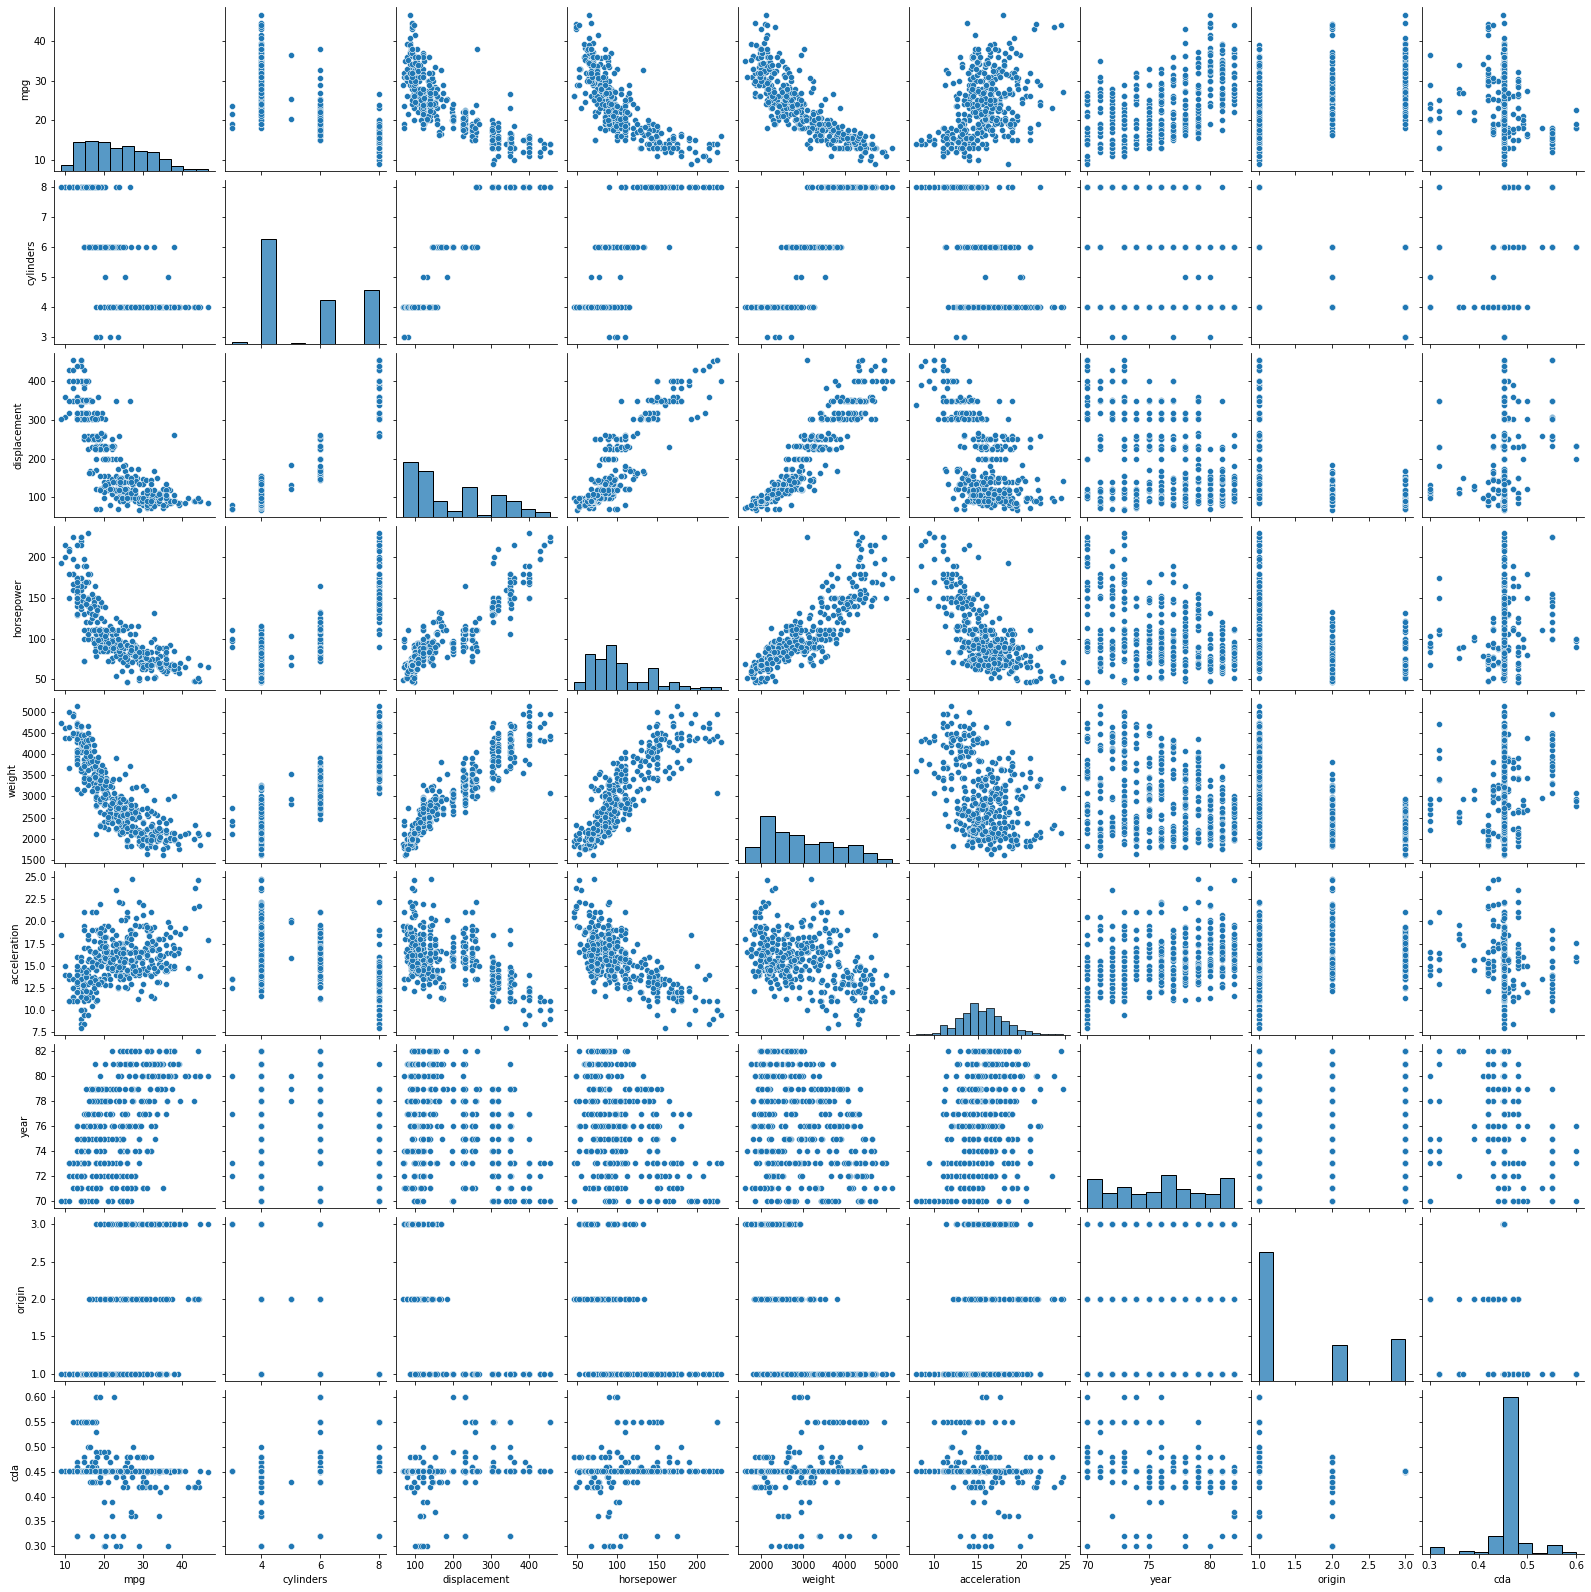

In [10]:
sns.pairplot(mtcars)

<AxesSubplot:ylabel='Count'>

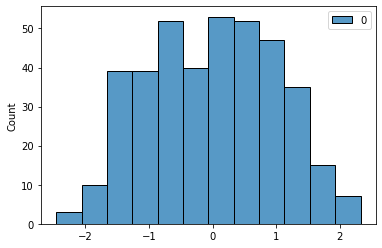

In [11]:
# сделаем ступенную трансформацию Yeo-Johnson, приводящую к более нормальному виду, отдельно для mpg
pt = PowerTransformer()
y = pt.fit_transform(mtcars.mpg.values.reshape(-1, 1))
sns.histplot(y)

сделаем переменную, где будут марки машин, возьмем только первое слово из имени авто.

In [12]:
pd.DataFrame(mtcars['name'].str.split(' ').str[0].value_counts()).sort_index()

,name
amc,27
audi,7
bmw,2
buick,17
cadillac,2
capri,1
chevroelt,1
chevrolet,43
chevy,3
chrysler,6


In [13]:
mtcars['maker'] = mtcars['name'].str.split(' ').str[0]
mtcars['maker'] = mtcars['maker'].replace(['vw', 'vokswagen'], 'volkswagen')
mtcars['maker'] = mtcars['maker'].replace(['toyouta'], 'toyota')
mtcars['maker'] = mtcars['maker'].replace(['maxda'], 'mazda')
mtcars['maker'] = mtcars['maker'].replace(['chevy', 'chevroelt'], 'chevrolet')
mtcars['maker'] = mtcars['maker'].replace(['mercedes'], 'mercedes-benz')

mtcars['maker'].value_counts()

ford             48
chevrolet        47
plymouth         31
dodge            28
amc              27
toyota           26
datsun           23
volkswagen       22
buick            17
pontiac          16
honda            13
mazda            12
mercury          11
oldsmobile       10
fiat              8
peugeot           8
audi              7
chrysler          6
volvo             6
saab              4
subaru            4
opel              4
mercedes-benz     3
renault           3
cadillac          2
bmw               2
triumph           1
capri             1
nissan            1
hi                1
Name: maker, dtype: int64

In [14]:
mtcars

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,cda,maker
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0.550000,chevrolet
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0.480000,buick
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0.452092,plymouth
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0.500000,amc
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0.452092,ford
...,...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl,0.460000,ford
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup,0.430000,volkswagen
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage,0.452092,dodge
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger,0.452092,ford


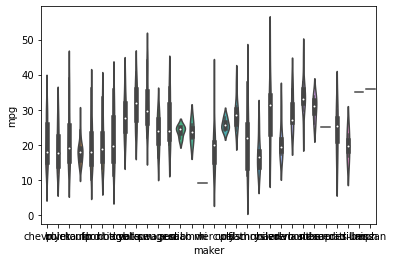

In [15]:
ax = sns.violinplot(x="maker", y="mpg", data=mtcars)

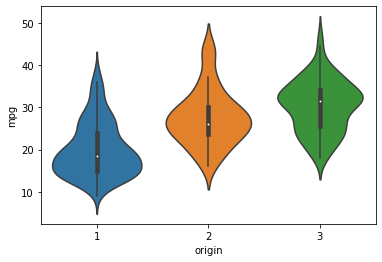

In [16]:
ax = sns.violinplot(x="origin", y="mpg", data=mtcars)

In [17]:
mtcars = mtcars.drop('name', axis = 1)
X = mtcars.drop('mpg', axis=1)

In [18]:
X

,cylinders,displacement,horsepower,weight,acceleration,year,origin,cda,maker
0,8,307.0,130,3504,12.0,70,1,0.550000,chevrolet
1,8,350.0,165,3693,11.5,70,1,0.480000,buick
2,8,318.0,150,3436,11.0,70,1,0.452092,plymouth
3,8,304.0,150,3433,12.0,70,1,0.500000,amc
4,8,302.0,140,3449,10.5,70,1,0.452092,ford
...,...,...,...,...,...,...,...,...,...
387,4,140.0,86,2790,15.6,82,1,0.460000,ford
388,4,97.0,52,2130,24.6,82,2,0.430000,volkswagen
389,4,135.0,84,2295,11.6,82,1,0.452092,dodge
390,4,120.0,79,2625,18.6,82,1,0.452092,ford


In [19]:
X.describe()

,cylinders,displacement,horsepower,weight,acceleration,year,origin,cda
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531,0.452092
std,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518,0.039171
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,0.300000
25%,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000,0.452092
50%,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,0.452092
75%,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000,0.452092
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,0.600000


In [20]:
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
set_config(display='diagram')

num_proc = make_pipeline(SimpleImputer(strategy='median'), PowerTransformer(method='box-cox'))

cat_proc = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='error', drop='first'))

preprocessor = make_column_transformer((num_proc, ('cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'cda')),
                                       (cat_proc, ('origin', 'maker')))

clf = make_pipeline(preprocessor)
clf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('powertransformer',
                                                                   PowerTransformer(method='box-cox'))]),
                                                  ('cylinders', 'displacement',
                                                   'horsepower', 'weight',
                                                   'acceleration', 'year',
                                                   'cda')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ('origin', 'maker'))]))])

In [21]:
clf.fit_transform(X)

<392x38 sparse matrix of type '<class 'numpy.float64'>'
	with 3256 stored elements in Compressed Sparse Row format>

In [22]:
a = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'cda']
a = a + [*clf.named_steps['columntransformer'].transformers_[1][1][1].get_feature_names(('origin', 'maker'))]


In [23]:
X_transformed = pd.DataFrame.sparse.from_spmatrix(clf.fit_transform(X), columns=a)
X_transformed

,cylinders,displacement,horsepower,weight,acceleration,year,cda,origin_2,origin_3,maker_audi,...,maker_peugeot,maker_plymouth,maker_pontiac,maker_renault,maker_saab,maker_subaru,maker_toyota,maker_triumph,maker_volkswagen,maker_volvo
0,1.330053,1.119083,0.854558,0.744740,-1.317005,-1.645286,2.670937,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.330053,1.324200,1.443474,0.919496,-1.522300,-1.645286,0.707305,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.330053,1.174932,1.215646,0.678813,-1.731625,-1.645286,-0.027823,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.330053,1.103403,1.215646,0.675865,-1.317005,-1.645286,1.251081,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.330053,1.092839,1.044478,0.691548,-1.945249,-1.645286,-0.027823,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,-0.889198,-0.285871,-0.329633,-0.047269,0.061052,1.617341,0.177648,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,-0.889198,-1.059673,-2.105501,-1.061211,2.983762,1.617341,-0.589872,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
389,-0.889198,-0.358965,-0.403978,-0.772356,-1.480927,1.617341,-0.027823,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,-0.889198,-0.601016,-0.601645,-0.268868,1.103411,1.617341,-0.027823,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
mtcars_transfromed = X_transformed.copy()
mtcars_transfromed['mpg'] = y
mtcars_transfromed

,cylinders,displacement,horsepower,weight,acceleration,year,cda,origin_2,origin_3,maker_audi,...,maker_plymouth,maker_pontiac,maker_renault,maker_saab,maker_subaru,maker_toyota,maker_triumph,maker_volkswagen,maker_volvo,mpg
0,1.330053,1.119083,0.854558,0.744740,-1.317005,-1.645286,2.670937,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.635451
1,1.330053,1.324200,1.443474,0.919496,-1.522300,-1.645286,0.707305,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.142697
2,1.330053,1.174932,1.215646,0.678813,-1.731625,-1.645286,-0.027823,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.635451
3,1.330053,1.103403,1.215646,0.675865,-1.317005,-1.645286,1.251081,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.965340
4,1.330053,1.092839,1.044478,0.691548,-1.945249,-1.645286,-0.027823,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.796543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,-0.889198,-0.285871,-0.329633,-0.047269,0.061052,1.617341,0.177648,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.561575
388,-0.889198,-1.059673,-2.105501,-1.061211,2.983762,1.617341,-0.589872,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.130750
389,-0.889198,-0.358965,-0.403978,-0.772356,-1.480927,1.617341,-0.027823,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.091568
390,-0.889198,-0.601016,-0.601645,-0.268868,1.103411,1.617341,-0.027823,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673604


In [25]:
import statsmodels.api as sm

In [26]:
X_transformed.columns

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'year', 'cda', 'origin_2', 'origin_3', 'maker_audi', 'maker_bmw',
       'maker_buick', 'maker_cadillac', 'maker_capri', 'maker_chevrolet',
       'maker_chrysler', 'maker_datsun', 'maker_dodge', 'maker_fiat',
       'maker_ford', 'maker_hi', 'maker_honda', 'maker_mazda',
       'maker_mercedes-benz', 'maker_mercury', 'maker_nissan',
       'maker_oldsmobile', 'maker_opel', 'maker_peugeot', 'maker_plymouth',
       'maker_pontiac', 'maker_renault', 'maker_saab', 'maker_subaru',
       'maker_toyota', 'maker_triumph', 'maker_volkswagen', 'maker_volvo'],
      dtype='object')

In [27]:
m2 = smf.ols('mpg ~  horsepower + weight  + year + origin_2   + maker_datsun + maker_ford  + maker_mercury + maker_pontiac + maker_volkswagen ', data=mtcars_transfromed)
m2fitted = m2.fit()

print(m2fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     357.5
Date:                Mon, 02 Aug 2021   Prob (F-statistic):          4.91e-180
Time:                        01:09:23   Log-Likelihood:                -116.55
No. Observations:                 392   AIC:                             253.1
Df Residuals:                     382   BIC:                             292.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0205      0.022  

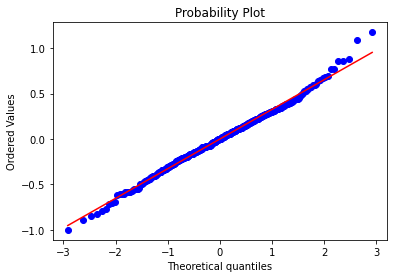

In [28]:

f = stats.probplot(m2fitted.resid, dist="norm", plot = plt)

In [29]:
m2fitted.f_test("maker_datsun  + maker_ford +maker_mercury + maker_pontiac + maker_volkswagen= 0")

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.04547774]]), p=0.8312417452836545, df_denom=382, df_num=1>

# выводы
* Тест Jarque-Bera на нормальность остатков и из визуальный анализ указывает, что гипотезу о их нормальном распределении отвергнуть нельзя. Следовательно, можно говорить о том, что мы можем смотеть на выводы по значимости факторов

* мы смогли перебором добиться значимости на 5% всех включенных факторов, кроме $\alpha$ 
* на F-тесте мы видим, что добавление дамми переменных по маркам авто является занчимым
* у финальной модели 0,894 $R^2$

По знакам признаков:

* мощные и тяжелые машины менее экономичные
* с годами машины становились экономичнее
* в америке менее экномичные машины, чем в европе (интересно, что если объединить origin2 и 3, то этот фактор незначимый)
* datsun и pontiac более экономичные при прочих равных
* mercury, ford и volkswagen менее экномичные при прочих равных

# Задание 4

В файлеhomes.csvсодержатся данные о цене продажи50домов
Что можно сказать о связи первых двух признаков? Постройте (хорошую) линейную регрессию дляпризнака Sell с и без признака List. Не забудьте о преобразовании признаков, если они будут нужны.2


In [30]:
homes = pd.read_csv('data/homes.csv', quoting=2, quotechar='"', skipinitialspace=True)
homes

,Sell,List,Living,Rooms,Beds,Baths,Age,Acres,Taxes
0,142.0,160.0,28.0,10.0,5.0,3.0,60.0,0.28,3167.0
1,175.0,180.0,18.0,8.0,4.0,1.0,12.0,0.43,4033.0
2,129.0,132.0,13.0,6.0,3.0,1.0,41.0,0.33,1471.0
3,138.0,140.0,17.0,7.0,3.0,1.0,22.0,0.46,3204.0
4,232.0,240.0,25.0,8.0,4.0,3.0,5.0,2.05,3613.0
5,135.0,140.0,18.0,7.0,4.0,3.0,9.0,0.57,3028.0
6,150.0,160.0,20.0,8.0,4.0,3.0,18.0,4.00,3131.0
7,207.0,225.0,22.0,8.0,4.0,2.0,16.0,2.22,5158.0
8,271.0,285.0,30.0,10.0,5.0,2.0,30.0,0.53,5702.0
9,89.0,90.0,10.0,5.0,3.0,1.0,43.0,0.30,2054.0


<AxesSubplot:xlabel='List', ylabel='Sell'>

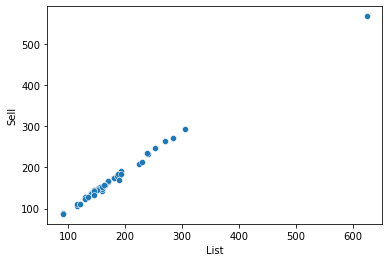

In [31]:
sns.scatterplot(x = 'List', y = 'Sell', data = homes)

In [32]:
scipy.stats.pearsonr(homes.List, homes.Sell)

(0.9974326270722506, 1.256595937604753e-56)

Корреляция между запрошенной ценой и ценой продажи более 0,99, значимая. Глядя на их распределение - почти линейная связь между этими значениями.

## Регрессия на цену продажи от цены выставления

In [33]:
h1 = smf.ols('Sell ~  List', data=homes)
h1fitted = h1.fit()

print(h1fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   Sell   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     9312.
Date:                Mon, 02 Aug 2021   Prob (F-statistic):           1.26e-56
Time:                        01:09:23   Log-Likelihood:                -152.97
No. Observations:                  50   AIC:                             309.9
Df Residuals:                      48   BIC:                             313.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3274      1.846      3.969      0.0

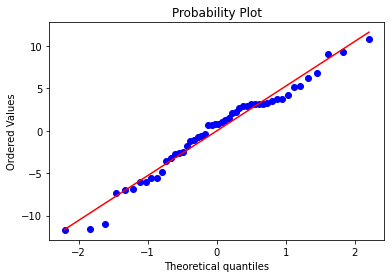

In [34]:
f = stats.probplot(h1fitted.resid, dist="norm", plot = plt)

In [35]:
k2, p = stats.normaltest(h1fitted.resid)
print("p = {:g}".format(p))
alpha = 0.01
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.531962
The null hypothesis cannot be rejected


видим, что нельзя отбросить гипотезу о нормальности отстков, у регрессии получился $R^2 = 0.995$, что соответствует нашим ожиданиям, что найдется линейная зависимость
## Регрессия на цену продажи от других переменных

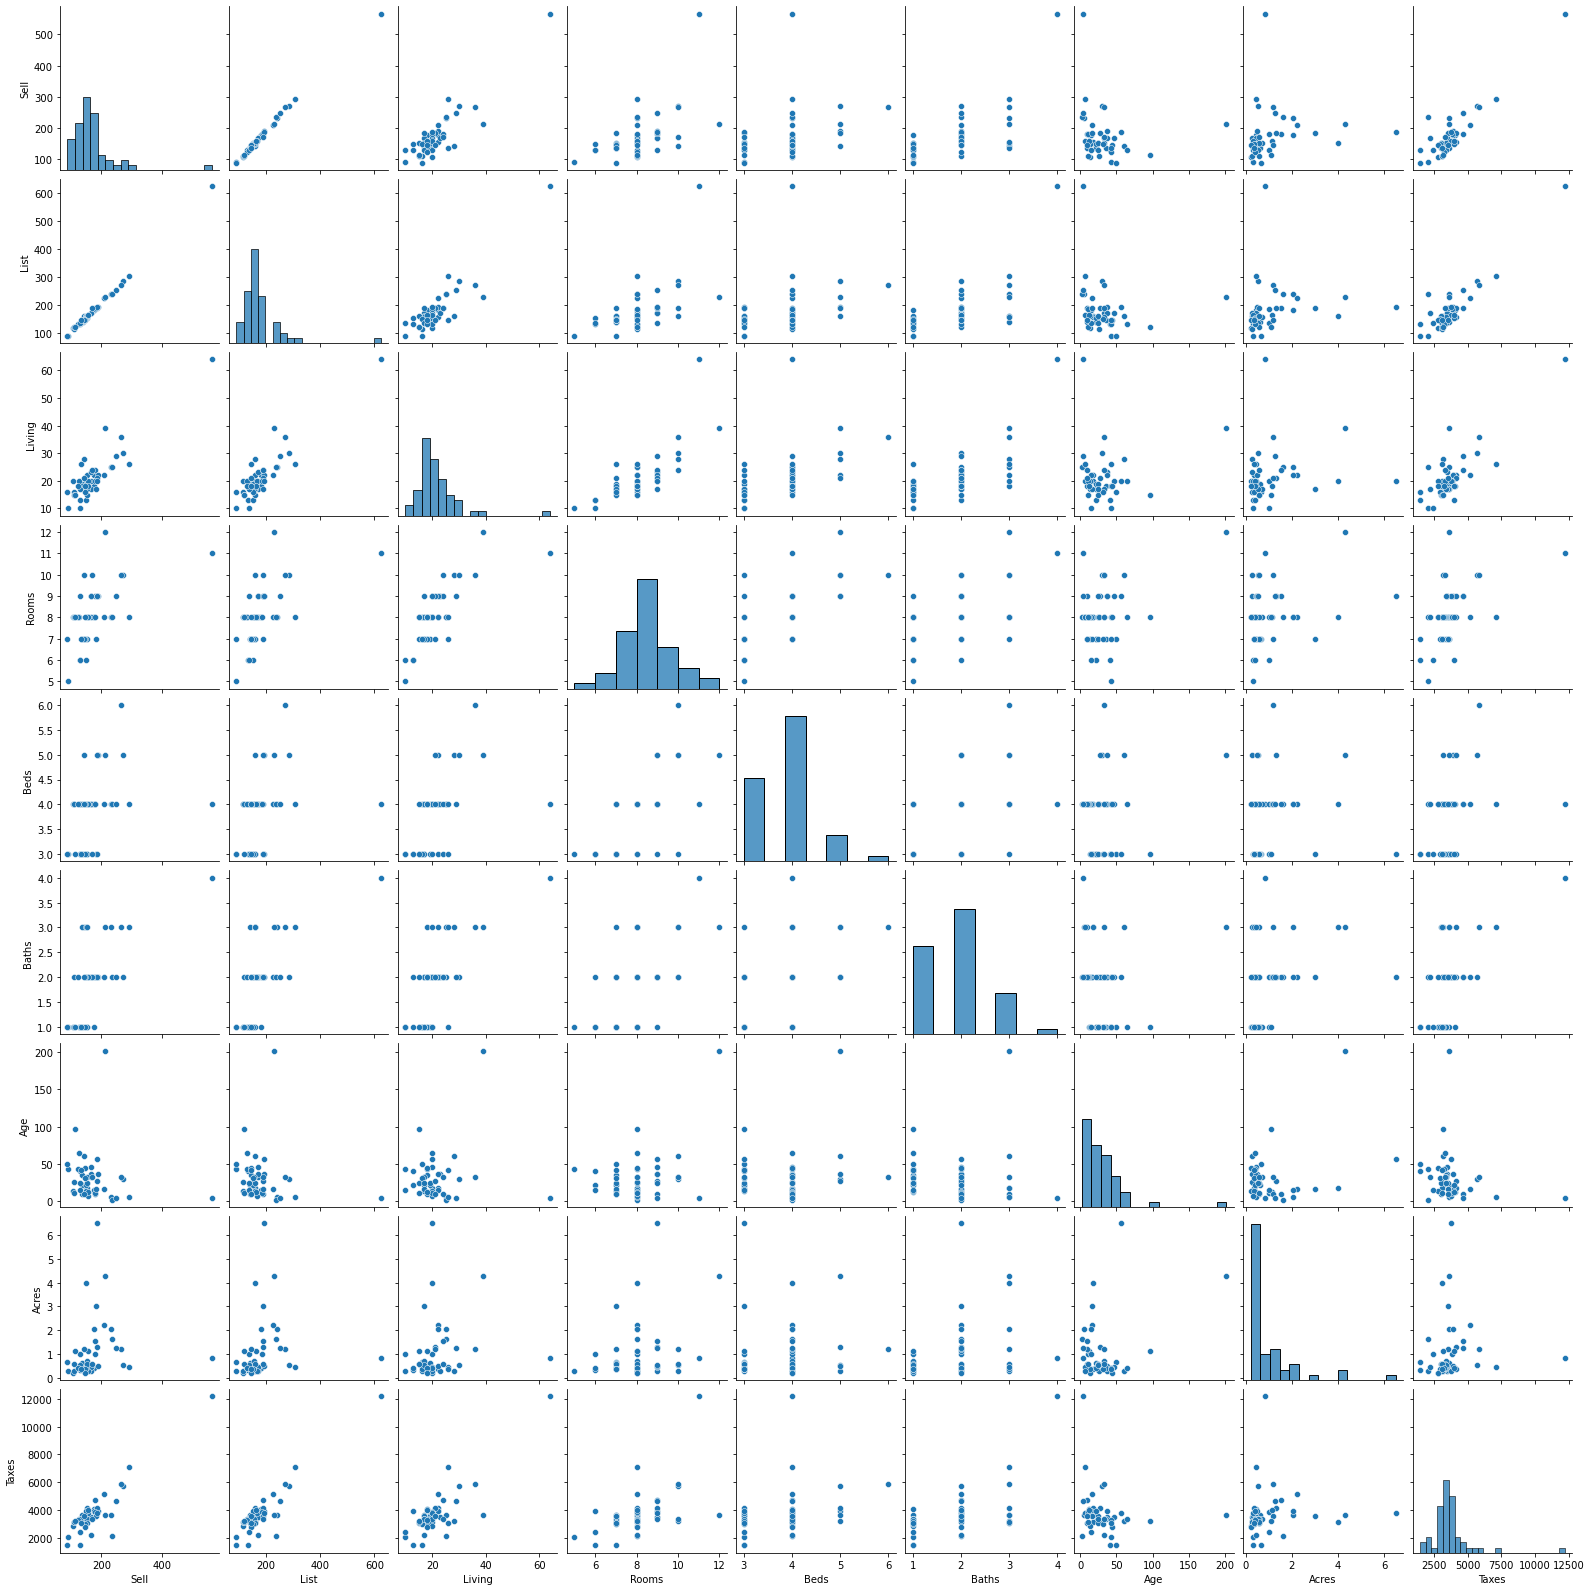

In [36]:
sns.pairplot(homes)

In [37]:
pt_h = PowerTransformer(method='box-cox')
transf_homes = pd.DataFrame(pt_h.fit_transform(homes), columns=homes.columns)

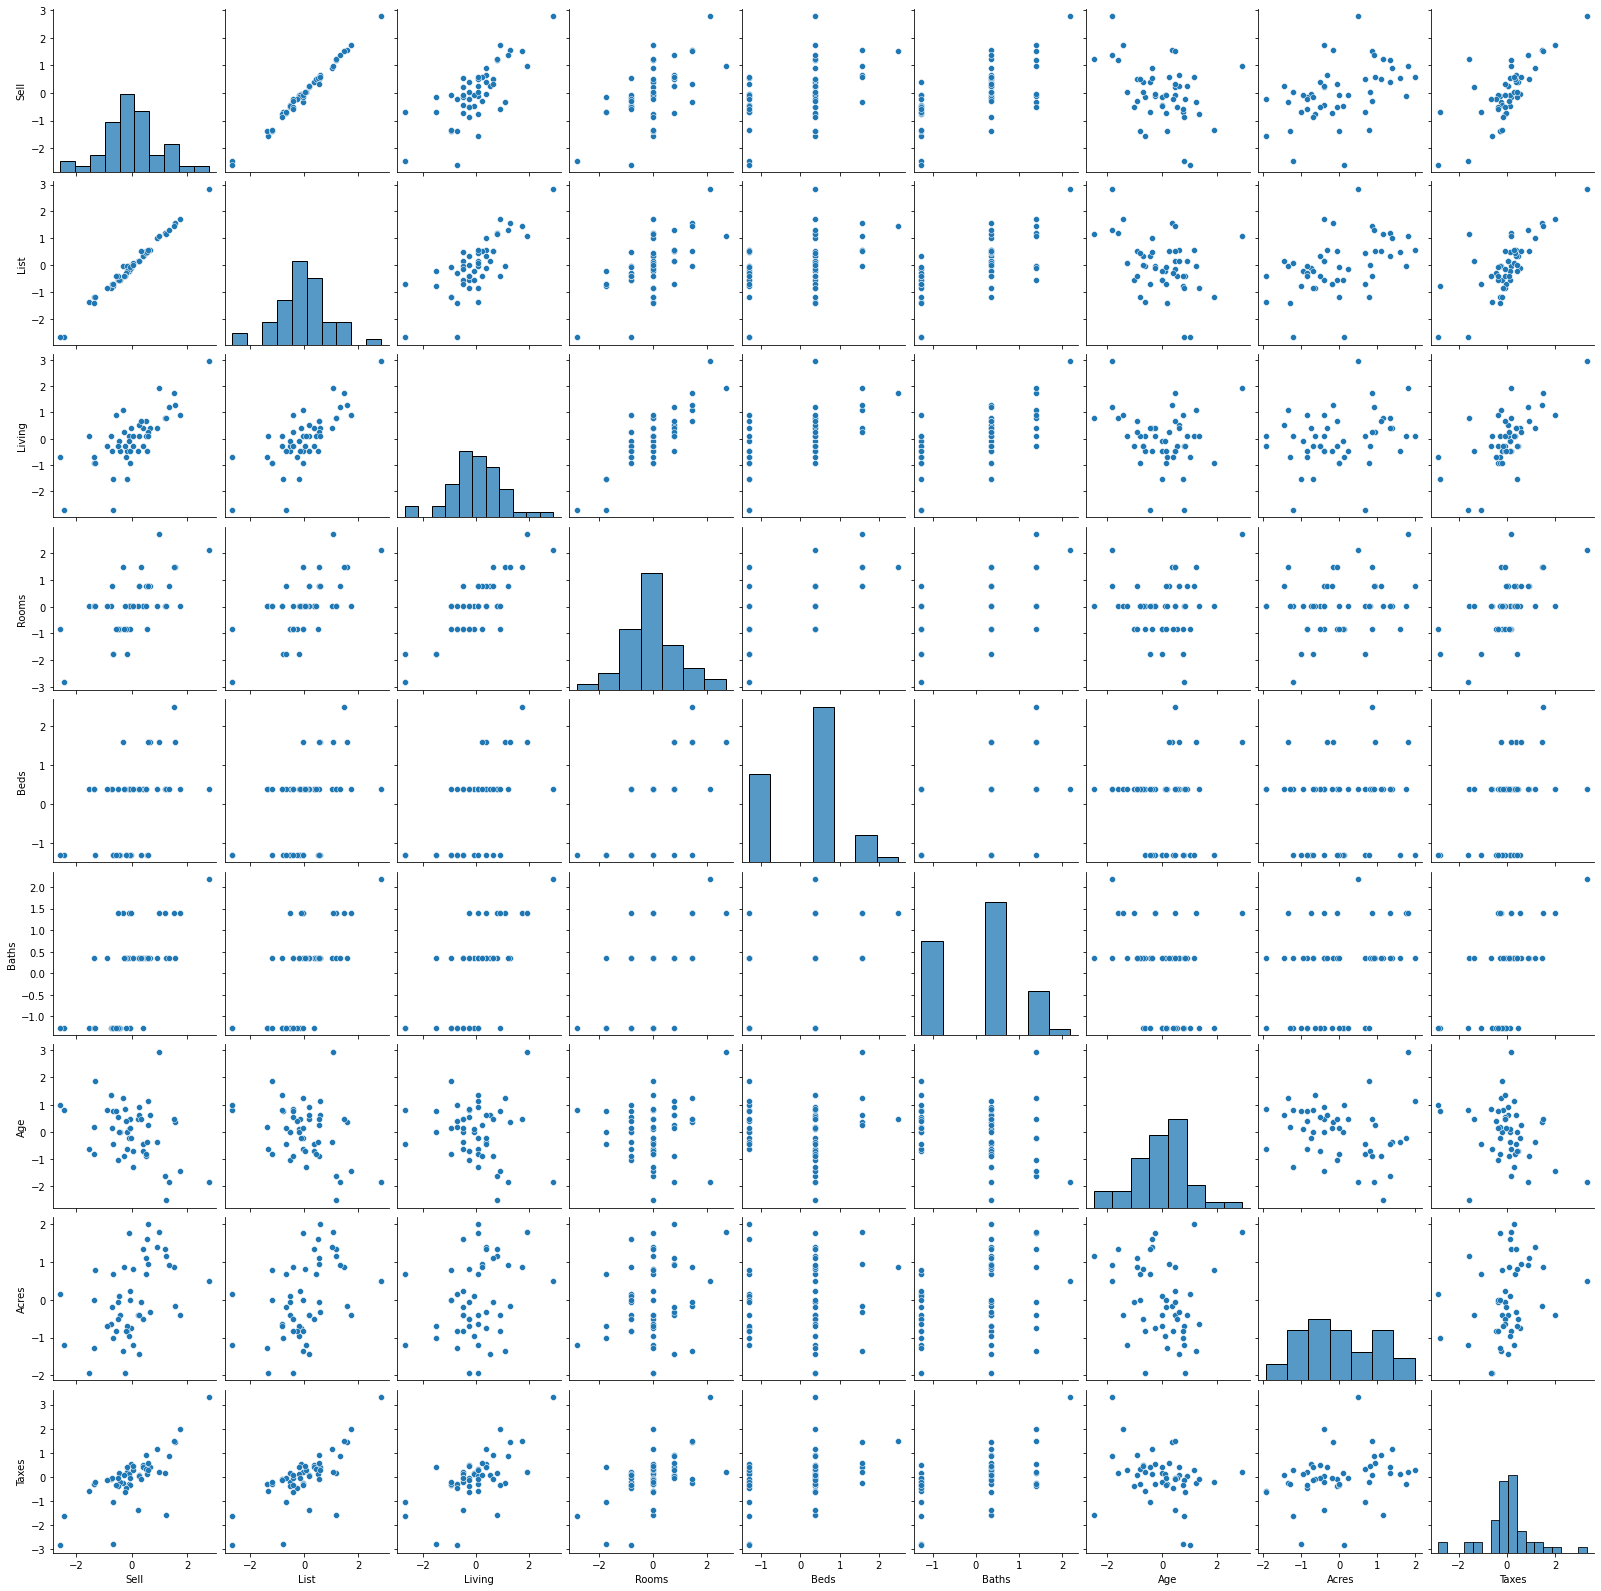

In [38]:
sns.pairplot(transf_homes)

In [39]:
transf_homes.columns

Index(['Sell', 'List', 'Living', 'Rooms', 'Beds', 'Baths', 'Age', 'Acres',
       'Taxes'],
      dtype='object')

In [40]:
h2 = smf.ols('Sell ~  Living + Rooms + Beds + Baths + Age + Acres + Taxes', data=transf_homes)
h2fitted = h2.fit()

print(h2fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   Sell   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     16.59
Date:                Mon, 02 Aug 2021   Prob (F-statistic):           2.90e-10
Time:                        01:09:54   Log-Likelihood:                -37.804
No. Observations:                  50   AIC:                             91.61
Df Residuals:                      42   BIC:                             106.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.046e-14      0.080  -1.32e-13      1.0

Встретили много мультиколлинеарности

In [44]:
shortlist = transf_homes[['Living', 'Rooms', 'Beds', 'Baths', 'Age', 'Acres', 'Taxes']]

In [45]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['Living', 'Rooms', 'Beds', 'Baths', 'Age', 'Acres', 'Taxes']
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(shortlist.values, i)
                          for i in range(len(shortlist.columns))]
vif_data

,feature,VIF
0,Living,4.356142
1,Rooms,4.849490
2,Beds,1.865011
3,Baths,1.944099
4,Age,1.519285
5,Acres,1.174239
6,Taxes,1.956570


удалим комнаты

In [46]:
h3 = smf.ols('Sell ~  Living  + Age + Acres + Taxes', data=transf_homes)
h3fitted = h3.fit()

print(h3fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   Sell   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     29.30
Date:                Mon, 02 Aug 2021   Prob (F-statistic):           5.11e-12
Time:                        01:16:24   Log-Likelihood:                -38.893
No. Observations:                  50   AIC:                             87.79
Df Residuals:                      45   BIC:                             97.35
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.046e-14      0.079  -1.33e-13      1.0

In [47]:
pt_sell = PowerTransformer(method='box-cox')
pt_sell.fit_transform(homes.Sell.values.reshape(-1,1))

r2_score(homes.Sell, pt_sell.inverse_transform(h3fitted.predict().reshape(-1,1)))

0.8962674896769814

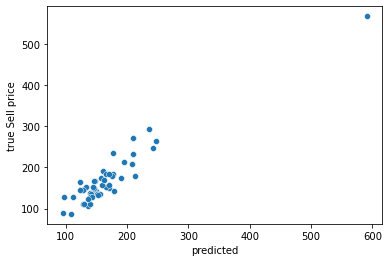

In [48]:
ax = sns.scatterplot(x = [item for sublist in pt_sell.inverse_transform(h3fitted.predict().reshape(-1,1)) for item in sublist], y = homes.Sell)
ax.set(xlabel='predicted', ylabel='true Sell price')
plt.show()

## Выводы

* Для модели, где допустима переменная List получился $R^2 > 0.99$
* Если провести трансформацию Бокса-Кокса над данными, убрать худшую по мультиколлинеарности переменную и удалить незначимые на 5% переменные, то мы получим $R^2 = 0.72$ для трансформированной цены.
* Когда мы сделаем обратную трансформацию в исходный вид целевой переменной, то $R^2 = 0.896$, что более сносно.